In [1]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [2]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
KKboxTransac_1 = pd.read_csv("transactions.csv")
KKboxTransac_2 = pd.read_csv("transactions_v2.csv")

In [6]:
KKboxTransac = pd.concat([KKboxTransac_1, KKboxTransac_2], axis=0)

In [7]:
# 如有記憶體優化需求時可用
del KKboxTransac_1
del KKboxTransac_2

In [23]:
KKboxTransac.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,membership_days
6797850,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,0,0,5.000
1914756,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,28.000
1498592,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,29.000
17923235,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,31.000
58566,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,31.000


In [24]:
KKboxTransac.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22437106 entries, 6797850 to 9570304
Data columns (total 8 columns):
msno                  category
payment_method_id     int8
payment_plan_days     int16
plan_list_price       int16
actual_amount_paid    int16
is_auto_renew         int8
is_cancel             int8
membership_days       float64
dtypes: category(1), float64(1), int16(3), int8(3)
memory usage: 934.2 MB


In [10]:
KKboxTransac.describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
count,22978755.000,22978755.000,22978755.000,22978755.000,22978755.000,22978755.000,22978755.000,22978755.000
mean,38.870,33.499,148.722,150.664,0.848,20158275.175,20159401.719,0.039
std,3.624,39.856,170.451,171.461,0.359,6627.848,8128.208,0.193
min,1.000,0.000,0.000,0.000,0.000,20150101.000,19700101.000,0.000
25%,38.000,30.000,99.000,99.000,1.000,20150922.000,20151102.000,0.000
50%,41.000,30.000,149.000,149.000,1.000,20160414.000,20160527.000,0.000
75%,41.000,30.000,149.000,149.000,1.000,20161022.000,20161127.000,0.000
max,41.000,450.000,2000.000,2000.000,1.000,20170331.000,20361015.000,1.000


-------

##### 型態轉換處理(優化記憶體、日期轉換)

In [11]:
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
KKboxTransac.rename(columns=date_rename,inplace=True)

In [12]:
del date_rename

In [13]:
KKboxTransac = dtype_compressor(KKboxTransac)

In [14]:
d = ['trans_date', 'mem_expire_date']
for col in d:
  KKboxTransac[col] = fast_datetime(KKboxTransac[col])

In [15]:
KKboxTransac = KKboxTransac.sort_values(by=['msno','trans_date'])

---

##### 將mem_expire_date - trans_date得到合約天數membership_days

In [16]:
KKboxTransac['membership'] = KKboxTransac['mem_expire_date'] - KKboxTransac['trans_date']

In [17]:
KKboxTransac['membership_days'] = KKboxTransac['membership'] / np.timedelta64(1,'D')

##### 刪除mem_expire_date、trans_date與membership欄位

In [18]:
KKboxTransac = KKboxTransac.drop(columns=['mem_expire_date','trans_date', 'membership'])

In [19]:
KKboxTransac = KKboxTransac.sort_values(by=['msno','membership_days'])
KKboxTransac.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,membership_days
6797850,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,0,0,5.000
1521480,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,0,410.000
249714,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,0,471.000
1914756,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,28.000
1498592,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,29.000


----

##### 在觀察KKBOX的所有方案中，最大方案天數為365天，這邊先濾去不合理的值

In [20]:
KKboxTransac = KKboxTransac[KKboxTransac["membership_days"] >= 0]

In [21]:
KKboxTransac = KKboxTransac[KKboxTransac["membership_days"] <= 365]

In [22]:
KKboxTransac.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,membership_days
6797850,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,0,0,5.000
1914756,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,28.000
1498592,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,29.000
17923235,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,31.000
58566,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,0,31.000


------

##### 觀察各特徵

* **特徵payment_method_id：**

付款方式共含 40 種，其中以編號41數量最多


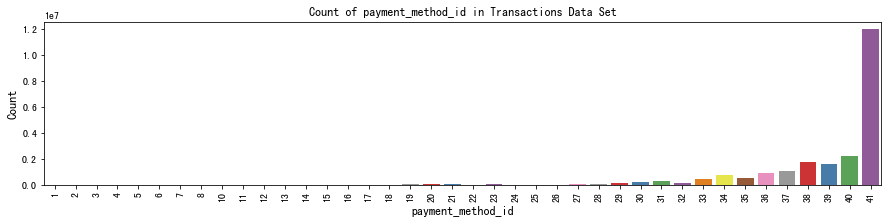

In [26]:
print('付款方式共含', end=' ')
print(len(KKboxTransac['payment_method_id'].unique()),end=' ')
print('種，其中以編號41數量最多')
plt.figure(figsize=(15,3))
sns.countplot(x="payment_method_id", data=KKboxTransac, palette = "Set1")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of payment_method_id in Transactions Data Set", fontsize=12)
plt.show()

* **特徵payment_plan_days：**

方案天數有 34 種，其中以30天方案(月費)數量最多


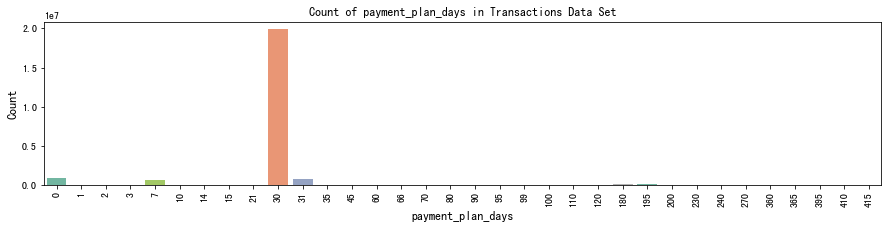

In [28]:
print('方案天數有', end=' ')
print(len(KKboxTransac['payment_plan_days'].unique()),end=' ')
print('種，其中以30天方案(月費)數量最多')
plt.figure(figsize=(15,3))
sns.countplot(x="payment_plan_days", data=KKboxTransac, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_plan_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of payment_plan_days in Transactions Data Set", fontsize=12)
plt.show()

* **特徵plan_list_price：**

方案價格有 54 種，其中以149元方案數量最多


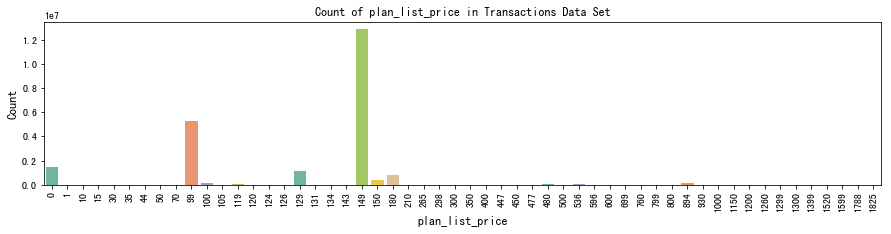

In [29]:
print('方案價格有', end=' ')
print(len(KKboxTransac['plan_list_price'].unique()),end=' ')
print('種，其中以149元方案數量最多')
plt.figure(figsize=(15,3))
sns.countplot(x="plan_list_price", data=KKboxTransac, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of plan_list_price in Transactions Data Set", fontsize=12)
plt.show()

* **特徵actual_amount_paid：**

實際付費價格共有 59 種，其中以149元方案數量最多


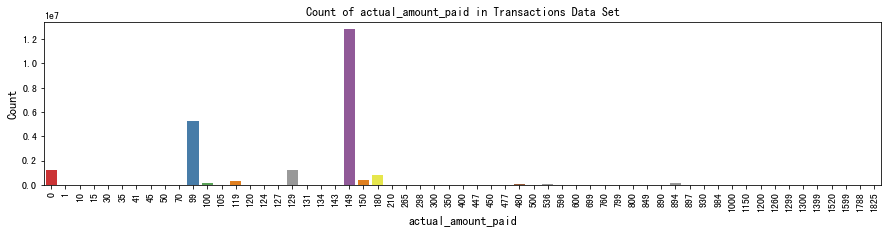

In [30]:
print('實際付費價格共有', end=' ')
print(len(KKboxTransac['actual_amount_paid'].unique()),end=' ')
print('種，其中以149元方案數量最多')
plt.figure(figsize=(15,3))
sns.countplot(x="actual_amount_paid", data=KKboxTransac, palette = "Set1")
plt.ylabel('Count', fontsize=12)
plt.xlabel('actual_amount_paid', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of actual_amount_paid in Transactions Data Set", fontsize=12)
plt.show()

* **特徵"plan_list_price"與"actual_amount_paid"相關性達89%，故可以只看"plan_list_price"**

In [31]:
print('plan_list_price與actual_amount_paid相關性達',end='')
print(100*KKboxTransac['plan_list_price'].corr(KKboxTransac['actual_amount_paid'],method='pearson'),"%")

plan_list_price與actual_amount_paid相關性達89.2943016977657 %


* **特徵membership_days：**

實際方案天數共含 366 種


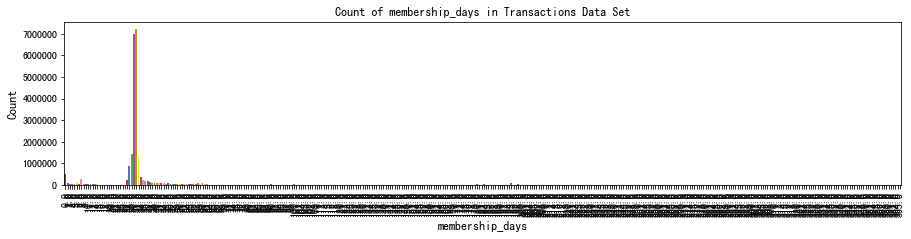

In [33]:
print('實際方案天數共含', end=' ')
print(len(KKboxTransac['membership_days'].unique()),end=' ')
print('種')
plt.figure(figsize=(15,3))
sns.countplot(x="membership_days", data=KKboxTransac, palette = "Set1")
plt.ylabel('Count', fontsize=12)
plt.xlabel('membership_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of membership_days in Transactions Data Set", fontsize=12)
plt.show()

* **特徵is_auto_renew：**

In [34]:
KKboxTransac["is_auto_renew"].value_counts()

1    19148991
0     3288115
Name: is_auto_renew, dtype: int64

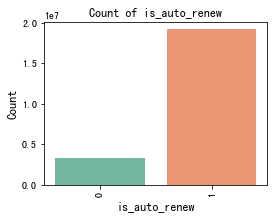

In [35]:
plt.figure(figsize=(4,3))
sns.countplot(x="is_auto_renew", data=KKboxTransac, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_auto_renew', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Count of is_auto_renew", fontsize=12)
plt.show()

##### 小結: Transaction的msno有重複的，表示同一個人有很多次交易紀錄

---

In [75]:
# 存成csv
KKboxTransac.to_csv('KKboxTransac.csv',index=False,header=True)